## Build train/val/test 

- Train
- Val
- Test

In [4]:
import os
import itertools
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import pandas as pd
from tqdm import tqdm

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [5]:
original_data_path = '../data/original'
filepaths = [os.path.join(original_data_path, f) for f in os.listdir(original_data_path) if f!='.DS_Store']

filepaths

['../data/original/Columbus Zoo',
 '../data/original/Cincinnati Zoo',
 '../data/original/National Zoo',
 '../data/original/Clean',
 '../data/original/._.DS_Store']

In [6]:
include_folders = ['../data/original/National Zoo',
 '../data/original/Cincinnati Zoo',
 '../data/original/Columbus Zoo']

In [7]:
data_folders = include_folders
labels = []

def get_labels(foldername):
    labels = [f for f in os.listdir(foldername) if f not in [".DS_Store",'._.DS_Store']]
    return labels

In [5]:
values = map(get_labels, data_folders)
labels.extend(values)
labels = list(itertools.chain(*labels))
labels

['Spike',
 'Swarna',
 'Kamala',
 'Maharani',
 'Schottzie',
 'Sabu',
 'Jati',
 'MyThai',
 'Sunny',
 'Connie',
 'Rudy',
 'Beco',
 'Pheobe',
 'Hank']

In [11]:

def walk_through_folders(data_folders):
    data = {}
    data['filepath']=[]
    data['image']=[]
    data['imagename'] = []
    data['label'] = []
    data["extension"] = []

    extension = set()
    empty_files = set()

    for image_folder in data_folders:
        for (dirpath, dirnames, filenames) in os.walk(image_folder):
            if dirnames == ".DS_Store":
                continue

            for f in tqdm(filenames):

                if f == ".DS_Store":
                    continue

                ## check image
                size = os.stat(os.path.join(dirpath,f)).st_size

                if size == 0:
                    empty_files.add(os.path.join(dirpath,f))
                    continue

                ## found two images - odd images - Hank_IMG_6061.JPG, Connie_IMG_3589
                label = os.path.basename(dirpath)
                imagename = f"{label}_{f}"


                if imagename in ['Connie_IMG_3589.JPG','Hank_IMG_6061.JPG']:
                    print("Ignoring image ",imagename)
                    continue

                filename, file_extension = os.path.splitext(f)

                ## check image files
                if file_extension==".JPG":
                    img = cv2.imread(os.path.join(dirpath, f))
                    if img is None:
                        continue

                    if len(img.shape)!=3:
                        print(img.shape)
                        continue

                data["extension"].append(file_extension)
                data['label'].append(label)
                data['image'].append(f)
                data['imagename'].append(imagename)
                data['filepath'].append(os.path.join(dirpath, f))
                
    return data, empty_files

In [15]:
df = pd.DataFrame(data)
print(f"No of files found: {df.shape[0]}")
df["extension"].value_counts()

df = df.loc[df['extension']!=".DS_Store"]
df = df.loc[df['extension']!=".AAE"]
print(df.shape)

No of files found: 19184
(19181, 5)


In [16]:
df["extension"].value_counts()

.JPG    18136
.MOV     1045
Name: extension, dtype: int64

In [ ]:
## 



In [17]:
df.to_csv("all_files_elephant_dataset.csv")

In [45]:
df = pd.read_csv("all_files_elephant_dataset.csv")
print(df.shape)
df = df.loc[:,["filepath","image","imagename","label","extension"]]

(19181, 6)


In [46]:
df.head()

,filepath,image,imagename,label,extension
0,../data/original/National Zoo/Spike/IMG_0941.JPG,IMG_0941.JPG,Spike_IMG_0941.JPG,Spike,.JPG
1,../data/original/National Zoo/Spike/IMG_0443.JPG,IMG_0443.JPG,Spike_IMG_0443.JPG,Spike,.JPG
2,../data/original/National Zoo/Spike/IMG_0778.JPG,IMG_0778.JPG,Spike_IMG_0778.JPG,Spike,.JPG
3,../data/original/National Zoo/Spike/IMG_1047.JPG,IMG_1047.JPG,Spike_IMG_1047.JPG,Spike,.JPG
4,../data/original/National Zoo/Spike/IMG_0358.JPG,IMG_0358.JPG,Spike_IMG_0358.JPG,Spike,.JPG


## Build Train and Validation Sets

- Train - all images excluding superclean images
- Validation - Only superclean images

In [21]:
## Retrieve all super-clean
clean_data, empty_clean_images =  walk_through_folders(['../data/original/Clean'])
clean_data_df = pd.DataFrame(clean_data)



0it [00:00, ?it/s]
100%|██████████| 11/11 [00:02<00:00,  4.29it/s]


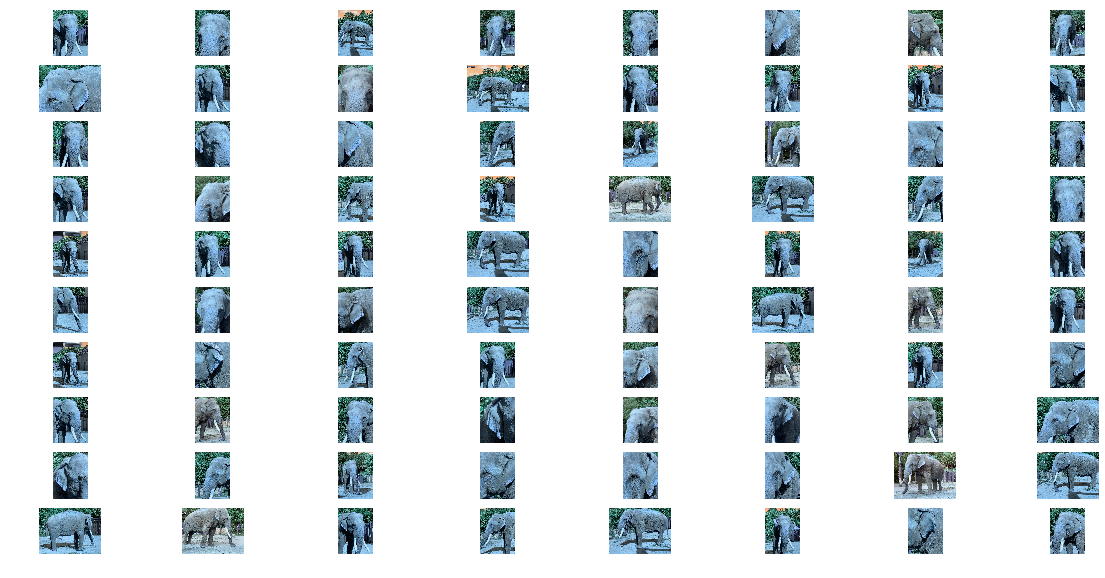

In [19]:
import imageio
from IPython.display import display, Image

def show_images(df):
    n_row = 10
    n_col = 8
    _, axs = plt.subplots(n_row, n_col, figsize=(20, 10))
    axs = axs.flatten()
    imgs = df.loc[:100,["filepath"]].values.astype(str)
    
    for img, ax in zip(imgs, axs):
        filename, file_extension = os.path.splitext(img[0])
        if file_extension in [".DS_Store",".AAE"]:
            continue
        
        ax.imshow(cv2.imread(img[0]))
        ax.grid(False)
        ax.axis("off")
    
    plt.axis("off")
    plt.show()
    
show_images(df)

### Move SuperClean into Validation Set:


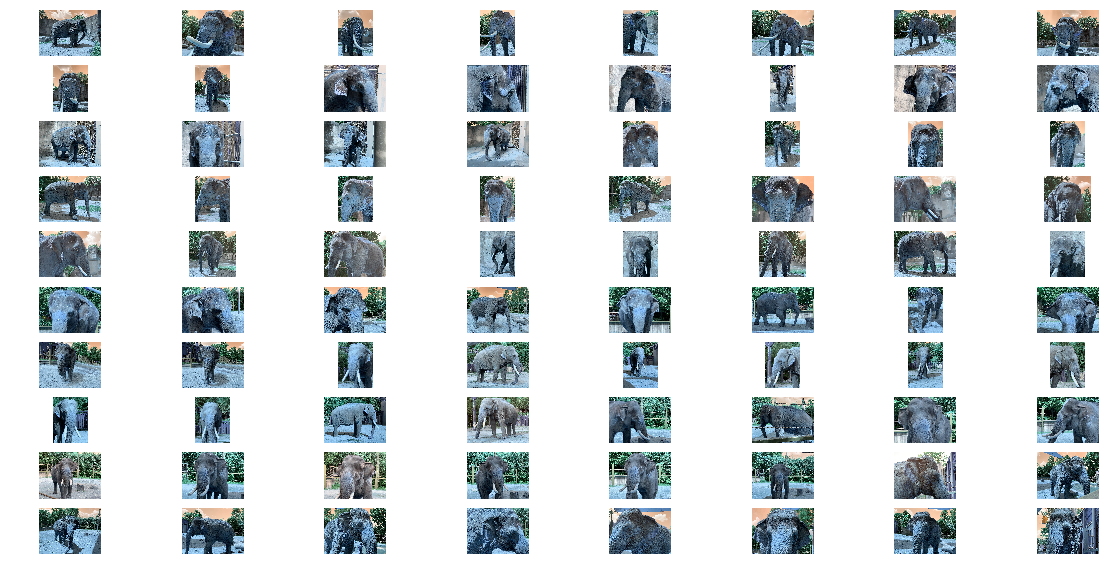

In [20]:
show_images(clean_data_df)

In [30]:
import shutil  

def save_all_clean_images_val(df,path):
    
    for idx, row in df.iterrows():
        extension = row["extension"]
        label = row["label"]
        
        parts = os.path.split(row["image"])
        filename = parts[-1]
        
        if not os.path.exists(os.path.join(path,label)):
            os.makedirs(os.path.join(path,label))
        
        ## resize and save
        shutil.copyfile(row["filepath"],os.path.join(path,label,row["image"]))

val_path = "../data/dataset/val"
save_all_clean_images_val(clean_data_df,val_path)

In [23]:
clean_data_df.columns


Index(['filepath', 'image', 'imagename', 'label', 'extension'], dtype='object')

In [ ]:
print(f"No of empty files: {len(empty_files)}")

## Move the rest to train


In [74]:
def check_value_in(img,l):
    found = False
    for i, row in clean_data_df.iterrows():
        image = str(row["image"])
        label = str(row["label"])
        if img==image and l==label:
            found = True
            return found
    return found

is_clean = []
for i, row in df.iterrows():
    image = str(row["image"])
    label = str(row["label"])
    is_clean.append(check_value_in(image,label))
    

In [85]:
import numpy as np
train_df  = df[df["is_clean"]==False]


(array([], dtype=int64),)

## Distribution of Labels

## Train

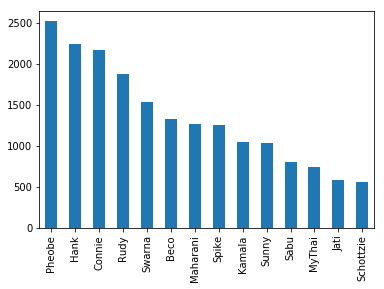

In [89]:
train_df["label"].value_counts().plot(kind="bar")

.JPG    17996
.MOV     1044
Name: extension, dtype: int64


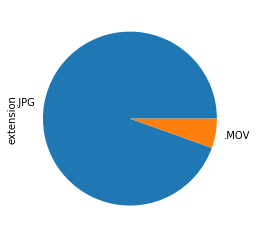

In [90]:
train_df['extension'] = train_df['filepath'].apply(lambda f: os.path.splitext(f)[1])
print(train_df['extension'].value_counts())
train_df["extension"].value_counts().plot(kind="pie")

In [92]:
train_df.shape

(19040, 6)

In [93]:
def create_dir_not_exists(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

create_dir_not_exists("../data/dataset/train")


## Convert video to images

- resize the image

In [98]:
## Create images from mov files
dim = (224, 224)

def getFrame(vidcap,sec,path):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        print('Original Dimensions : ',image.shape)
        resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
        cv2.imwrite(path, resized)     # save frame as JPG file
    return hasFrames

def get_images(save_path, video_file_path,filename):
    frameRate = 0.5 # capture image in each 0.5 second
    image_write_path  = lambda count: os.path.join(save_path,"%s_frame%d.jpg" % (filename,count))
    count=1
    sec = 0
    vidcap = cv2.VideoCapture(video_file_path)
    success = getFrame(vidcap,sec,image_write_path(count))
    while success:
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)
        success = getFrame(vidcap,sec,image_write_path(count))
        
## resize image
def resize_image(imgpath,savepath):
    img = cv2.imread(imgpath)
    #print('Original Dimensions : ',img.shape)
    
    # resize image
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    cv2.imwrite(savepath, resized)
    return savepath

In [99]:
train_df.head()

,filepath,image,imagename,label,extension,is_clean
0,../data/original/National Zoo/Spike/IMG_0941.JPG,IMG_0941.JPG,Spike_IMG_0941.JPG,Spike,.JPG,False
1,../data/original/National Zoo/Spike/IMG_0443.JPG,IMG_0443.JPG,Spike_IMG_0443.JPG,Spike,.JPG,False
2,../data/original/National Zoo/Spike/IMG_0778.JPG,IMG_0778.JPG,Spike_IMG_0778.JPG,Spike,.JPG,False
3,../data/original/National Zoo/Spike/IMG_1047.JPG,IMG_1047.JPG,Spike_IMG_1047.JPG,Spike,.JPG,False
4,../data/original/National Zoo/Spike/IMG_0358.JPG,IMG_0358.JPG,Spike_IMG_0358.JPG,Spike,.JPG,False


In [100]:
def save_images(df,path):
    for idx, row in df.iterrows():
        extension = row["extension"]
        current_file_path = row["filepath"]
        label = row["label"]
        
        newimagename = row["imagename"]
        
        if not os.path.exists(os.path.join(path,label)):
            os.makedirs(os.path.join(path,label))
        
        
        ### check extension
        if extension==".MOV":
            get_images(os.path.join(path,label), current_file_path,newimagename)
        else:
            ## resize and save
            resize_image(current_file_path,os.path.join(path,label,newimagename))

            

### Save Train/Test/Val

In [101]:
train_save_path = os.path.join("../data/dataset/train")
save_images(train_df, train_save_path)


print("Completed train")


Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1920, 3)
Original Dimensions :  (1080, 1920, 3)
Original Dimensions :  (1080, 1920, 3)
Original Dimensions :  (1080, 1920, 3)
Original Dimensions :  (1080, 1920, 3)
Original Dimensions :  (1080, 1920, 3)
Original Dimensions :  (1080, 1920, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1

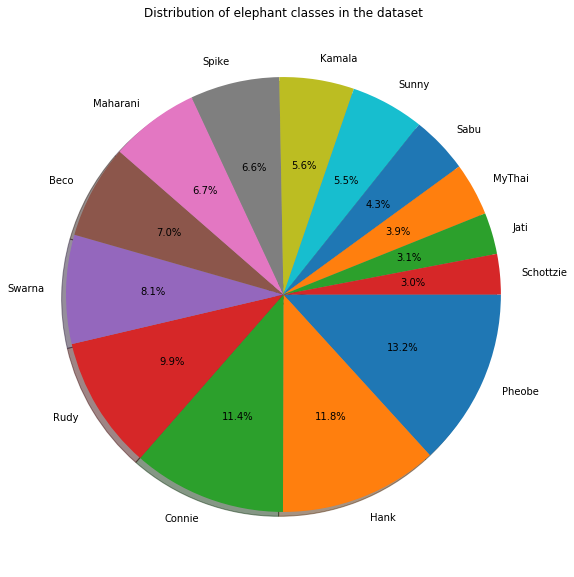

In [49]:
plt.figure(figsize=(20,10))
cnts = list(df["label"].value_counts())
cnts = [(i/sum(cnts))*100 for i in cnts]

#colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.title("Distribution of elephant classes in the dataset")
plt.pie(cnts, labels=df["label"].value_counts().keys(),
autopct='%1.1f%%',
counterclock=False, shadow=True)
plt.savefig("../images/distribution_of_labels.png")

In [59]:
sorted(Counter(df["label"]))

['Beco',
 'Connie',
 'Hank',
 'Jati',
 'Kamala',
 'Maharani',
 'MyThai',
 'Pheobe',
 'Rudy',
 'Sabu',
 'Schottzie',
 'Spike',
 'Sunny',
 'Swarna']

In [62]:
class_dic = sorted(df["label"].value_counts().items(), key=lambda x: x[1], reverse=True)

In [63]:
## top 5

In [68]:
keys = [a[0] for a in class_dic[:6]]

### Save Data for Top 5 classes

In [70]:
top_5_classes_df = df[df["label"].isin(keys)]

In [74]:
top_5_classes_df.head()

,filepath,image,imagename,label,extension
1272,../data/original/National Zoo/Swarna/IMG_9472.JPG,IMG_9472.JPG,Swarna_IMG_9472.JPG,Swarna,.JPG
1273,../data/original/National Zoo/Swarna/IMG_9879.JPG,IMG_9879.JPG,Swarna_IMG_9879.JPG,Swarna,.JPG
1274,../data/original/National Zoo/Swarna/IMG_9482.JPG,IMG_9482.JPG,Swarna_IMG_9482.JPG,Swarna,.JPG
1275,../data/original/National Zoo/Swarna/IMG_9066.JPG,IMG_9066.JPG,Swarna_IMG_9066.JPG,Swarna,.JPG
1276,../data/original/National Zoo/Swarna/IMG_9824.JPG,IMG_9824.JPG,Swarna_IMG_9824.JPG,Swarna,.JPG


In [73]:
top_5_classes_df.shape

(11780, 5)

In [77]:
## Percent of total data
11780*100/df.shape[0]

61.41494186955842

#### Split dataset

In [78]:
X_train_top5, X_test_top5, y_train_top5, y_test_top5 = train_test_split(top_5_classes_df['filepath'], top_5_classes_df['label'],
                                                    stratify=top_5_classes_df['label'], 
                                                    test_size=0.2)


In [79]:
X_train_top5, X_val_top5, y_train_top5, y_val_top5  = train_test_split(X_train_top5, y_train_top5, test_size=0.1, random_state=1)

In [80]:
print(f"No of train:{X_train_top5.shape}, No of val: {X_val_top5.shape}, No of test: {X_test_top5.shape}")

No of train:(8481,), No of val: (943,), No of test: (2356,)


Pheobe    1827
Hank      1645
Connie    1602
Rudy      1365
Swarna    1095
Beco       947
Name: labels, dtype: int64

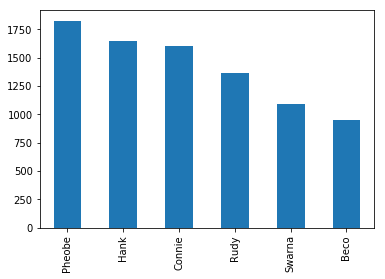

In [83]:
train_top5_df = pd.DataFrame({"labels":y_train_top5,"images":X_train_top5})
train_top5_df["labels"].value_counts().plot(kind="bar")
train_top5_df["labels"].value_counts()

Pheobe    204
Hank      165
Rudy      153
Connie    149
Swarna    148
Beco      124
Name: labels, dtype: int64

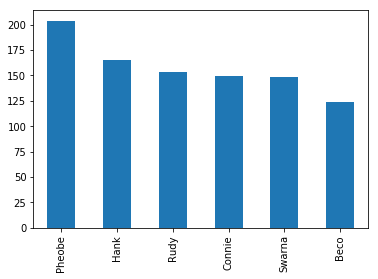

In [85]:
val_top5_df = pd.DataFrame({"labels":y_val_top5,"images":X_val_top5})
val_top5_df["labels"].value_counts().plot(kind="bar")
val_top5_df["labels"].value_counts()

Pheobe    508
Hank      453
Connie    438
Rudy      379
Swarna    310
Beco      268
Name: labels, dtype: int64

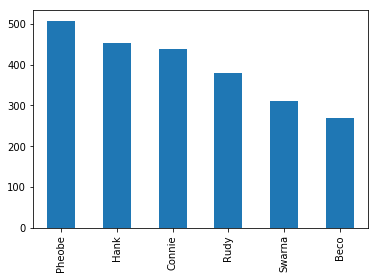

In [86]:
test_top5_df = pd.DataFrame({"labels":y_test_top5,"images":X_test_top5})
test_top5_df["labels"].value_counts().plot(kind="bar")
test_top5_df["labels"].value_counts()

### Save the data


In [88]:
train_top5_df['extension'] = train_top5_df['images'].apply(lambda f: os.path.splitext(f)[1])
val_top5_df['extension'] = val_top5_df['images'].apply(lambda f: os.path.splitext(f)[1])
test_top5_df['extension'] = test_top5_df['images'].apply(lambda f: os.path.splitext(f)[1])

train_top5_save_path = os.path.join("../data/dataset/top5/train")
save_images(train_top5_df, train_top5_save_path)


print("Completed train")

val_top5_save_path = os.path.join("../data/dataset/top5/val")
save_images(val_top5_df, val_top5_save_path)

print("Completed val")
test_top5_save_path = os.path.join("../data/dataset/top5/test")
save_images(test_top5_df, test_top5_save_path)

print("Completed test")

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (4

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3

Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (1080, 1440, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (4032, 3024, 3)
Original Dimensions :  (3024, 4032, 3)
Original Dimensions :  (3

Original Dimensions :  (3024, 4032, 3)
Completed test
